In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from DynamicModel_Package.ModelBase import DynamicModel


In [3]:
def dxdt (variables,params):
    a     = params["a"]
    b     = params["b"]
    d     = params["d"]
    k     = params["k"]
    K     = params["K"]    
    x = variables['x']
    p = variables['p']

    return a + (b + d) * (x * p) / (k + p) - d * x - b * K * x**2

def diIdt (variables,params):
    alpha = params["alpha"]
    beta  = params["beta"]
    delta = params["delta"]
    K     = params["K"]
    s     = params["s"]    
    x = variables['x']
    iI = variables['iI']

    return alpha + (beta + delta) * (iI * x) / (s + x) - delta * iI - beta * K * iI**2

def dpdt (variables,params):
    K     = params["K"]
    r     = params["r"]
    m     = params["m"]
    v     = params["v"]
    iI = variables['iI']
    p = variables['p']

    return p * (r - m * iI / (v + iI)) - r * K * p


params = {
    "a": 0.05, "b": 2.5, "d": 2.5,
    "alpha": 0.05, "beta": 2.5, "delta": 2.5,
    "k": 1e4, "K": 1e-8, "s": 1e4,
    "r": 2.5, "m": 5.0, "v": 1e5
}

params = {
    "a": 0.05, "b": 2.5, "d": 2.5,
    "alpha": 0.05, "beta": 2.5, "delta": 2.5,
    "k": 1e4, "K": 1e-8, "s": 1e4,
    "r": 2.5, "m": 5.0, "v": 1e5
}

def init_model_frank (parameters):
    model_frank = DynamicModel()
    model_frank.add_variable('x',dxdt,parameters)
    model_frank.add_variable('iI',diIdt,parameters)
    model_frank.add_variable('p',dpdt,parameters)
    return model_frank 

model_frank = init_model_frank(params)


(          t         x        iI             p
 0      0.00  0.020000  0.020000      1.000000
 1      0.01  0.020000  0.020000      1.025000
 2      0.02  0.020000  0.020000      1.050625
 3      0.03  0.020000  0.020000      1.076891
 4      0.04  0.020000  0.020000      1.103813
 ...     ...       ...       ...           ...
 3996  39.96  0.080170  0.022212  30083.112440
 3997  39.97  0.081674  0.022157  30835.189910
 3998  39.98  0.083216  0.022103  31606.069308
 3999  39.99  0.084796  0.022050  32396.220684
 4000  40.00  0.086416  0.021999  33206.125836
 
 [4001 rows x 4 columns],
 <Figure size 640x480 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'x'}>,
        <AxesSubplot: title={'center': 'iI'}>,
        <AxesSubplot: title={'center': 'p'}>], dtype=object))

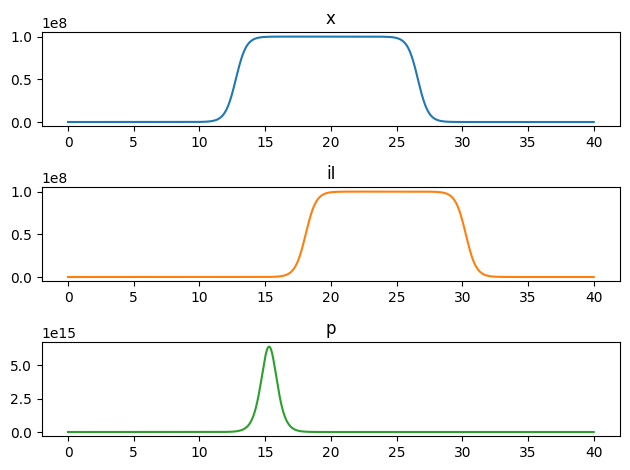

In [4]:
y0 = {'x':params["a"] / params["d"], 'iI':params["alpha"] / params["delta"], 'p':1.0,'t':0.0}

model_frank.integrate_and_plot(y0,40,0.01,True,['x','iI','p'],['tab:blue','tab:orange','tab:green'])

In [5]:
def compute_fwhm(t, y):
    """
    Compute Full Width at Half Maximum (FWHM) for a 1D time series y(t).
    
    Parameters:
    - t: time points (1D array)
    - y: signal values (1D array)
    
    Returns:
    - fwhm_time: duration for which y > 0.5 * max(y)
    - t_start, t_end: time bounds of FWHM interval
    """
    half_max = 0.5 * np.max(y)
    above_half = y > half_max
    if not np.any(above_half):
        return 0.0, None, None

    indices = np.where(above_half)[0]
    t_start = t[indices[0]]
    t_end = t[indices[-1]]
    fwhm_time = t_end - t_start
    return fwhm_time, t_start,  t_end

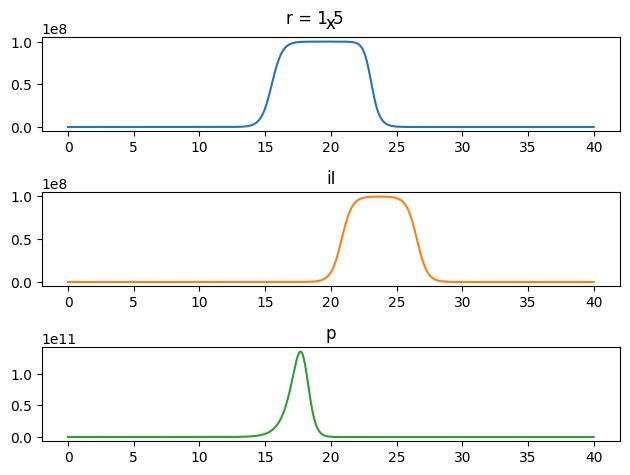

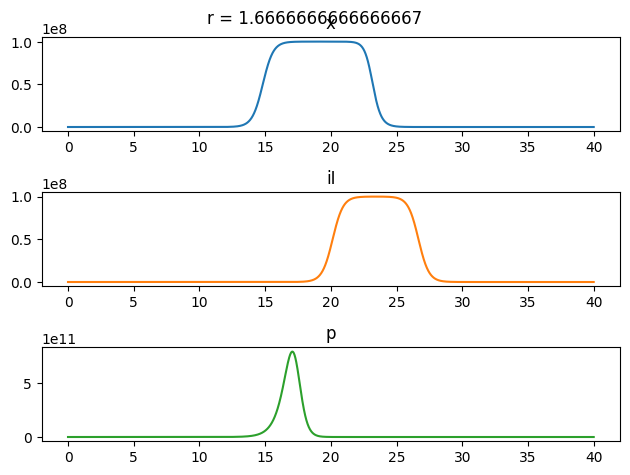

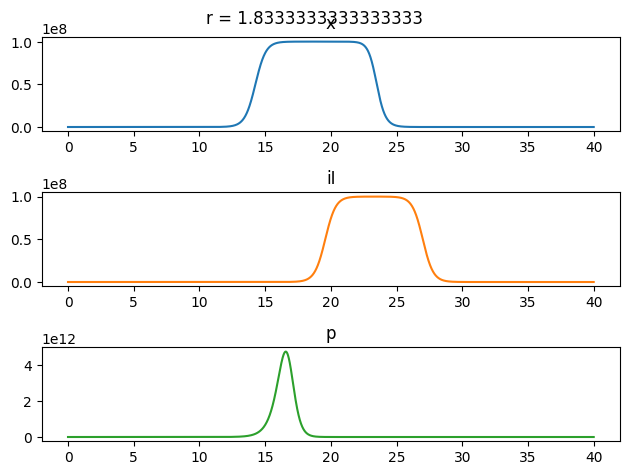

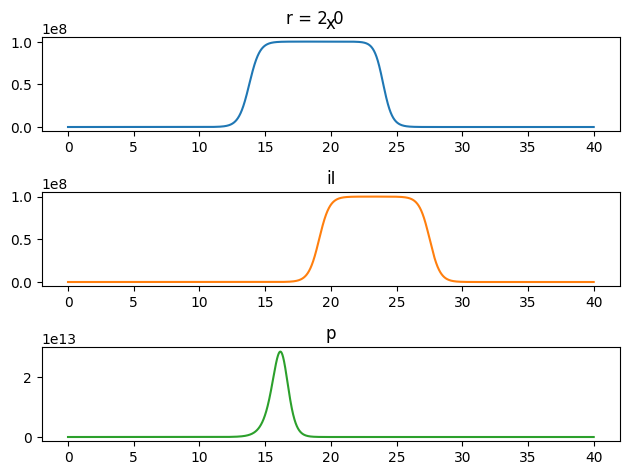

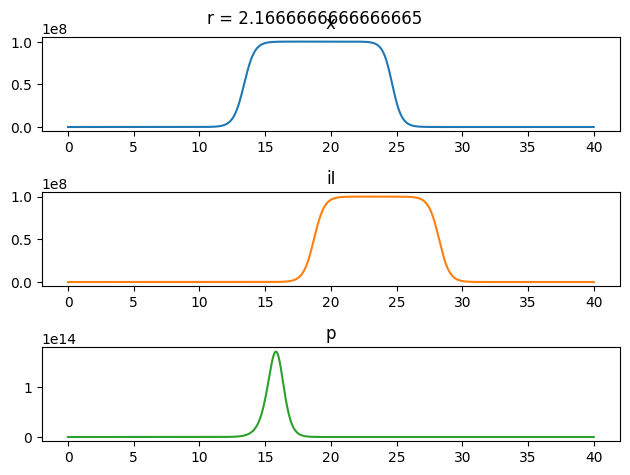

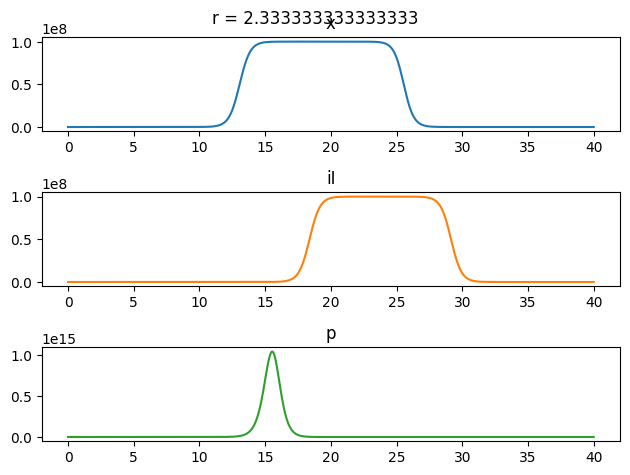

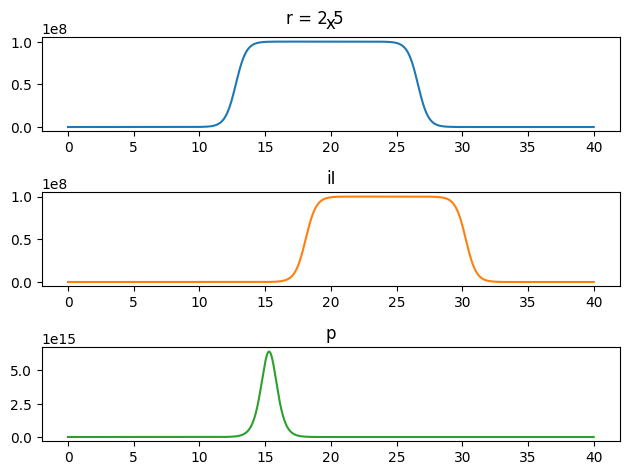

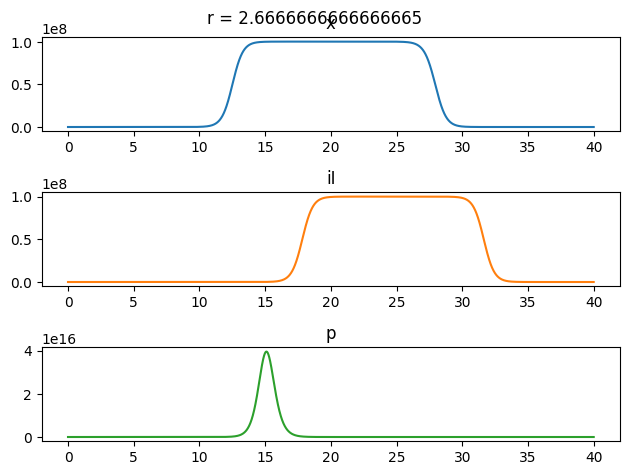

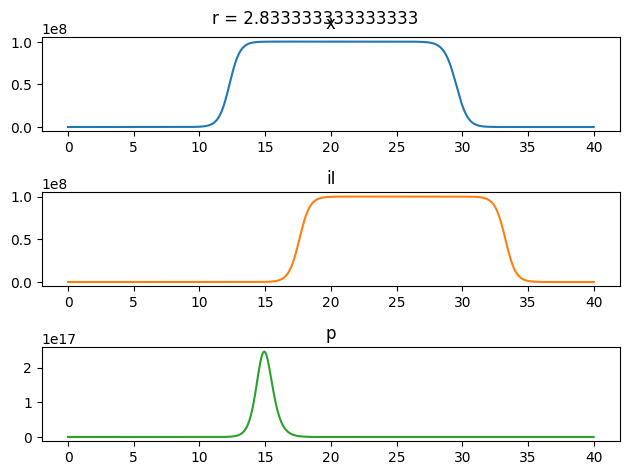

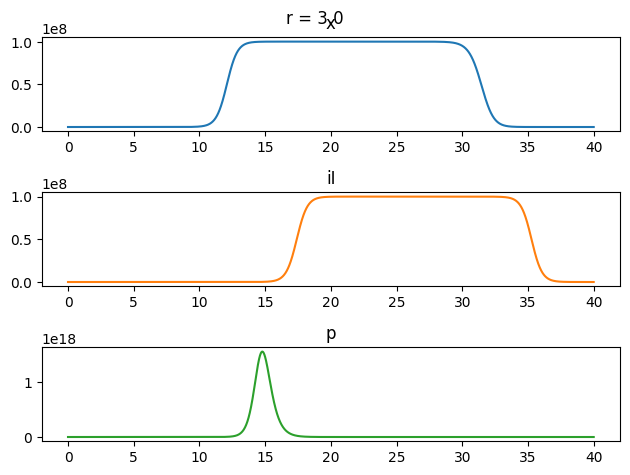

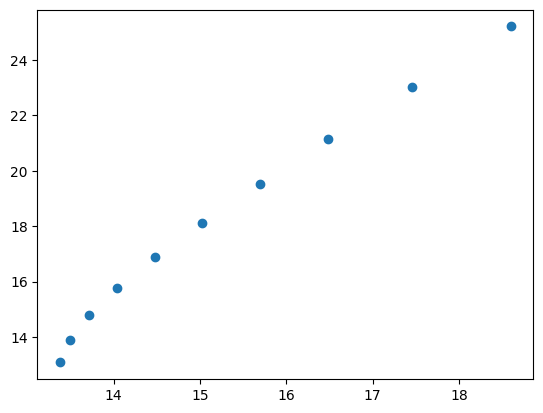

In [6]:
rs = np.linspace(1.5,3,10)
fwhm_is = []
fwhm_ps = []

amp_is = []
amp_ps = []
for r in rs:
    params['r'] = r
    model_frank = init_model_frank(params)
    df,fig,ax  =model_frank.integrate_and_plot(y0,40,0.01,True,['x','iI','p'],['tab:blue','tab:orange','tab:green'])
    fig.suptitle(f'r = {r}')
    fwhm_p, _, _ = compute_fwhm(df['t'], np.log(df['p']))
    fwhm_i, _,_ = compute_fwhm(df['t'], np.log(df['iI']))
    fwhm_is.append(fwhm_i)
    fwhm_ps.append(fwhm_p)
    amp_ps.append(df['p'].max())
    amp_is.append(df['iI'].max())

fig,ax = plt.subplots()
ax.scatter(fwhm_ps,fwhm_is)


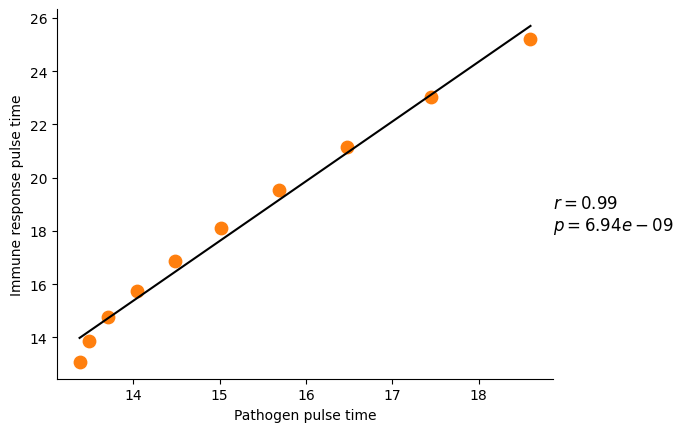

In [7]:
fig,ax = plt.subplots()
ax.spines[['top','right']].set_visible(False)
ax.scatter(fwhm_ps,fwhm_is, s = 80, color = 'tab:orange')

from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(fwhm_ps,fwhm_is)
y_fit = slope * np.array(fwhm_ps) + intercept
ax.plot(fwhm_ps, y_fit, color='black', label=f'Fit: y={slope:.2f}x+{intercept:.2f}')
ax.text(1, 0.5, f'$r = {r_value:.2f}$ \n$ p = {p_value:.2e}$', transform=plt.gca().transAxes,
    verticalalignment='top', fontsize=12)

ax.set_xlabel('Pathogen pulse time')
ax.set_ylabel('Immune response pulse time')
fig.savefig('frank_corr.png',dpi = 600)
fig.savefig('frank_corr.pdf',dpi = 600)



In [20]:
fwhms = np.array([fwhm_ps,fwhm_is])
np.save('frank_fwhms',fwhms)


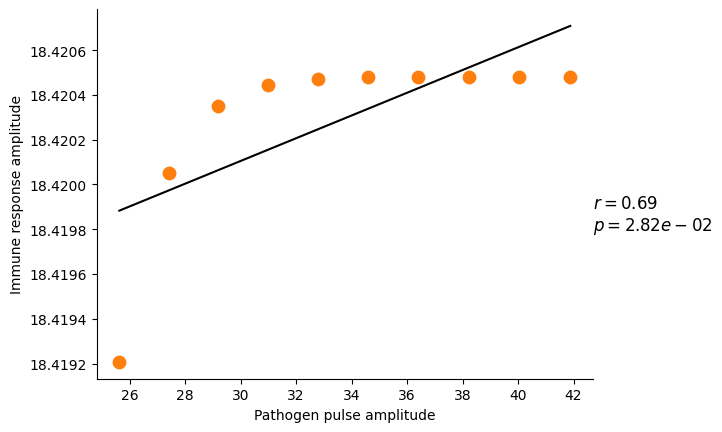

In [9]:
fig,ax = plt.subplots()
ax.spines[['top','right']].set_visible(False)
amp_ps = np.log(amp_ps)
amp_is = np.log(amp_is)
ax.scatter(amp_ps,amp_is, s = 80, color = 'tab:orange')

from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(amp_ps,amp_is)
y_fit = slope * np.array(amp_ps) + intercept
ax.plot(amp_ps, y_fit, color='black', label=f'Fit: y={slope:.2f}x+{intercept:.2f}')
ax.text(1, 0.5, f'$r = {r_value:.2f}$ \n$ p = {p_value:.2e}$', transform=plt.gca().transAxes,
    verticalalignment='top', fontsize=12)

ax.set_xlabel('Pathogen pulse amplitude')
ax.set_ylabel('Immune response amplitude')
fig.savefig('frank_corr_amps.png',dpi = 600)
fig.savefig('frank_corr_amps.pdf',dpi = 600)

amps = np.array([amp_ps,amp_is])
np.save('frank_amps',amps)
